## FS PreEval Notebook: FI → FI-unique archetypes bootstrap

1. Bootstraps the FI/FS module from the project root.
2. Runs the FI pipeline (Stages 1-4) on the Cowrie_Sessions.csv dataset to produce a canonical FI CSV.
3. Extracts FI-unique archetypes (one representative session per unique FI hash) for use in FS evaluation.
4. Decodes the canonical JSON representation of each archetype back into triplet sequences for FS

In [1]:
# === FS PreEval Notebook: FI → FI-unique archetypes bootstrap ===

import sys, subprocess
from pathlib import Path
import json
import pandas as pd
import shutil
from IPython.display import display

# ------------------------------------------------------------------
# 0) Bootstrap project root + import FI/FS module
# ------------------------------------------------------------------
ROOT = Path(subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], text=True
).strip())
sys.path[:0] = [str(ROOT / "src")]

print("ROOT =", ROOT.name)

from fi_fs import (
    load_aggregated_csv,
    parse_dataframe_to_triplets,
    apply_aliases,
    apply_placeholders_args_only,
    assert_connectors_preserved,
    alpha_renumber,
    assert_serialisation_deterministic,
    build_fi_dataframe,
    write_fi_csv,
    load_alias_map_yaml
)

# ------------------------------------------------------------------
# 1) FI Pipeline: Stage 1-4 (canonical FI CSV)
# ------------------------------------------------------------------
DATASET = "Cowrie.csv"
INPUT_DATASET = ROOT / "projects" / "fi_fs" / "data" / "processed" / DATASET
DATASET_NAME = Path(INPUT_DATASET).stem

# Base output dir: projects/fi_fs/data/output/<dataset_name>/
OUTPUT_DIR = ROOT / "projects" / "fi_fs" / "data" / "output" / DATASET_NAME
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# FS_eval nested inside /output/<dataset_name>/FS_eval
FS_EVAL_DIR = OUTPUT_DIR / "FS_eval"
FS_EVAL_DIR.mkdir(parents=True, exist_ok=True)

FS_NP_ARRAY_DIR = FS_EVAL_DIR / "NumPy_Arrays"
FS_NP_ARRAY_DIR.mkdir(parents=True, exist_ok=True)

agg, stats = load_aggregated_csv(str(INPUT_DATASET))
print(f"\n--- FI Pipeline: Stage 1: Data Loading ---")
print("Loaded aggregated dataset from:", INPUT_DATASET.relative_to(ROOT))
print("Aggregated sessions:", stats["n_sessions"])
print("Rows per session — min/median/max:",
      stats["n_rows_min"], stats["n_rows_med"], stats["n_rows_max"])
display(agg.head(5))

# Stage 2: parse with bashlex → triplets (+ diagnostics)
seqs, parsed_parts, parse_df, problems = parse_dataframe_to_triplets(
    agg,
    progress=True,
    with_diagnostics=True,
    strict=False,
)
print(f"\n--- FI Pipeline: Stage 2: Bashlex Parsing ---")
print("Sequences built:", len(seqs))

# Restrict agg to successfully parsed sessions only
parsed_sids = set(seqs.keys())
agg_ok = agg[agg["session"].isin(parsed_sids)].copy()

print("\n--- FI Pipeline: Stage 2b: Filter parsed sessions ---")
print("Original agg sessions:   ", len(agg))
print("Sessions with sequences:", len(agg_ok))

# Optional safety check: seqs and agg_ok should have same sessions
missing_from_seqs = set(agg_ok["session"]) - parsed_sids
missing_from_agg  = parsed_sids - set(agg_ok["session"])
assert not missing_from_seqs, f"In agg_ok but not seqs: {list(missing_from_seqs)[:5]}"
assert not missing_from_agg,  f"In seqs but not agg_ok: {list(missing_from_agg)[:5]}"


# Stage 3: normalisation: aliases → placeholders → α-renumber
alias_map = load_alias_map_yaml(ROOT/ "src" / "fi_fs" / "resources" / "alias_map.yaml")
seqs_alias, alias_changes = apply_aliases(seqs, alias_map)
print(f"\n--- FI Pipeline: Stage 3: Normalisation & α-renumber ---")
print("Alias changes:", 0 if alias_changes is None else len(alias_changes))

seqs_ph, dbg = apply_placeholders_args_only(
    seqs_alias, debug=True,
    preview_changed_first_n_sessions=8,
    sample_per_reason=8,
)
assert_connectors_preserved(seqs_alias, seqs_ph)

seqs_alpha = alpha_renumber(seqs_ph, check_idempotent=True)
print("α-renumbered sessions:", len(seqs_alpha))

# --- Stage 4: FI table (serialise + hash) and save -----------------
assert_serialisation_deterministic(seqs_alpha)
fi_df = build_fi_dataframe(agg_ok, seqs_alpha, commands_col="commands_joined")

out_csv_str = write_fi_csv(fi_df, str(INPUT_DATASET))
out_csv = Path(out_csv_str)
if not out_csv.is_absolute():
    out_csv = Path.cwd() / out_csv

out_path = OUTPUT_DIR / out_csv.name
shutil.move(str(out_csv), out_path)

print("Wrote canonical FI CSV:", out_path.relative_to(ROOT))
out_path = Path(out_path)

# ------------------------------------------------------------------
# 2) FI-unique archetypes: one representative per fi_hash
# ------------------------------------------------------------------

# 2.1 Detect which commands column FI gave us
CMD_CANDIDATES = ["commands_clean", "commands_joined", "commands"]
cmd_col = next((c for c in CMD_CANDIDATES if c in fi_df.columns), None)
if cmd_col is None:
    raise KeyError(
        f"None of {CMD_CANDIDATES} found in fi_df.columns={list(fi_df.columns)}"
    )
print(f"Using '{cmd_col}' as commands column for archetypes.")

# 2.2 How many sessions per FI class?
class_sizes = (
    fi_df.groupby("fi_hash")["session"]
         .size()
         .rename("n_classes")
         .reset_index()
)

# 2.3 Deterministic representative per fi_hash:
#     - longest n_rows first (most "complete" behaviour)
#     - tie-break by session id (stable)
fi_sorted = (
    fi_df.sort_values(["n_rows", "session"], ascending=[False, True])
         .merge(class_sizes, on="fi_hash", how="left")
)

archetypes = (
    fi_sorted
      .drop_duplicates("fi_hash", keep="first")
      .assign(singleton=lambda df: df["n_classes"] == 1)
      [["session", "n_rows", "fi_hash", "singleton", "n_classes",
        cmd_col, "canonical_json"]]
      .rename(columns={cmd_col: "commands_clean"})  # standardise name
      .reset_index(drop=True)
)

# 2.4 Optional: write the __FI_representatives_with_singleton CSV
rep_out = out_path.with_name(out_path.stem + "__FI_representatives_with_singleton" + out_path.suffix)
rep_for_csv = archetypes[[
    "session", "n_rows", "fi_hash",
    "singleton", "n_classes",
    "commands_clean", "canonical_json"
]]
rep_for_csv.to_csv(rep_out, index=False)
print("Wrote FI representatives CSV:", rep_out.relative_to(ROOT))


# 2.5 Decode canonical_json into triplet sequences for FS
def decode_canonical(canon_json: str):
    """
    canonical_json: JSON like [["op", ["arg1","arg2"], "conn"], ...]
    returns: list[(op:str, args:tuple[str,...], conn:str)]
    """
    rows = json.loads(canon_json)
    return [(op, tuple(args), conn) for op, args, conn in rows]

archetypes["seq"] = archetypes["canonical_json"].map(decode_canonical)

print(f"\nFI-unique archetypes: {len(archetypes)} "
      f"(singletons: {(archetypes['singleton']).sum()})")
display(archetypes.head(5))

# Convenience for later FS cells:
seqs_unique = archetypes["seq"].tolist()
N = len(seqs_unique)
print(f"FS Eval will operate over N={N} FI-unique archetypes.")


ROOT = PhD
PYTHON: cpython 3.12.0
BASHLEX: 0.18

--- FI Pipeline: Stage 1: Data Loading ---
Loaded aggregated dataset from: projects/fi_fs/data/processed/Cowrie.csv
Aggregated sessions: 98513
Rows per session — min/median/max: 1 4 135


,session,n_rows,commands_joined
0,00031aeff1a6,5,sh\nshell\nenable\necho 'nameserver 95.214.27....
1,0003e7887230,5,sh\nshell\nenable\necho 'nameserver 95.214.27....
2,0003f10a2103,4,sh\nshell\nenable\ncat /bin/echo || while read...
3,0004025aa9c2,15,sh\nshell\nenable\ncd ~ && rm -rf .ssh && mkdi...
4,000537a9f749,1,uname -s -v -n -r -m


Parsing sessions (bashlex): 100%|██████████| 98513/98513 [01:07<00:00, 1458.87it/s]



--- FI Pipeline: Stage 2: Bashlex Parsing ---
Sequences built: 98425

--- FI Pipeline: Stage 2b: Filter parsed sessions ---
Original agg sessions:    98513
Sessions with sequences: 98425

--- FI Pipeline: Stage 3: Normalisation & α-renumber ---
Alias changes: 488
α-renumbered sessions: 98425
Wrote canonical FI CSV: projects/fi_fs/data/output/Cowrie/Cowrie_canonical.csv
Using 'commands_clean' as commands column for archetypes.
Wrote FI representatives CSV: projects/fi_fs/data/output/Cowrie/Cowrie_canonical__FI_representatives_with_singleton.csv

FI-unique archetypes: 607 (singletons: 241)


,session,n_rows,fi_hash,singleton,n_classes,commands_clean,canonical_json,seq
0,dd5701316fba,112,9e354a776b18ac92,True,1,enable\nsystem\nshell\nsh\nlinuxshell\ncd /tmp...,"[[""enable"",[],"";""],[""system"",[],"";""],[""shell"",...","[(enable, (), ;), (system, (), ;), (shell, (),..."
1,032039c09cf5,72,42e268c561eb252f,False,9,enable\nsystem\nshell\nsh\nlinuxshell\ncd /tmp...,"[[""enable"",[],"";""],[""system"",[],"";""],[""shell"",...","[(enable, (), ;), (system, (), ;), (shell, (),..."
2,0345ed3fbf9d,72,fac7676552a74851,False,5,enable\nsystem\nshell\nsh\nlinuxshell\ncd /tmp...,"[[""enable"",[],"";""],[""system"",[],"";""],[""shell"",...","[(enable, (), ;), (system, (), ;), (shell, (),..."
3,1ef53df25795,72,a71652faa5037fe3,False,7,enable\nsystem\nshell\nsh\nlinuxshell\ncd /tmp...,"[[""enable"",[],"";""],[""system"",[],"";""],[""shell"",...","[(enable, (), ;), (system, (), ;), (shell, (),..."
4,27d0b57dc6c8,72,6d0368812dfec155,False,10,enable\nsystem\nshell\nsh\nlinuxshell\ncd /tmp...,"[[""enable"",[],"";""],[""system"",[],"";""],[""shell"",...","[(enable, (), ;), (system, (), ;), (shell, (),..."


FS Eval will operate over N=607 FI-unique archetypes.


In [2]:
# === FS Eval: Agglomerative clustering + evaluation helpers ===

import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)

# -------------------------------------------------------------------
# 1) Agglomerative clustering helper on distance = 1 - FS
# -------------------------------------------------------------------

def cluster_agglomerative(FS: np.ndarray, tau: float) -> np.ndarray:
    """
    Average-link Agglomerative clustering on precomputed distance = 1 - FS.

    tau: similarity threshold. distance_threshold = 1 - tau.
    """
    dist = np.maximum(0.0, 1.0 - FS.astype(float))
    np.fill_diagonal(dist, 0.0)
    dist = 0.5 * (dist + dist.T)  # enforce symmetry

    try:
        agg = AgglomerativeClustering(
            linkage="average",
            n_clusters=None,
            distance_threshold=1.0 - tau,
            metric="precomputed",
        )
    except TypeError:
        # For older sklearn versions
        agg = AgglomerativeClustering(
            linkage="average",
            n_clusters=None,
            distance_threshold=1.0 - tau,
            affinity="precomputed",
        )

    labels = agg.fit_predict(dist)
    return labels

# -------------------------------------------------------------------
# 2) Dunn index from distance matrix + labels
# -------------------------------------------------------------------

def _dunn_index_from_distance(dist: np.ndarray, labels: np.ndarray) -> float:
    labs = np.asarray(labels)
    valid_mask = labs != -1
    labs = labs[valid_mask]
    dist = dist[valid_mask][:, valid_mask]

    unique = np.unique(labs)
    if unique.size < 2:
        return float("nan")

    # intra-cluster diameters
    diameters = []
    for c in unique:
        idx = np.where(labs == c)[0]
        if idx.size <= 1:
            diameters.append(0.0)
        else:
            sub = dist[np.ix_(idx, idx)]
            tri_i, tri_j = np.triu_indices(idx.size, 1)
            diameters.append(sub[tri_i, tri_j].max())
    max_diam = max(diameters) if diameters else float("nan")

    # inter-cluster distances
    inter = []
    for i, ci in enumerate(unique):
        idx_i = np.where(labs == ci)[0]
        for cj in unique[i+1:]:
            idx_j = np.where(labs == cj)[0]
            sub = dist[np.ix_(idx_i, idx_j)]
            inter.append(sub.min())
    min_inter = min(inter) if inter else float("nan")

    if max_diam == 0 or np.isnan(max_diam) or np.isnan(min_inter):
        return float("nan")
    return float(min_inter / max_diam)

# -------------------------------------------------------------------
# 3) Clustering evaluation helper (reused across lanes)
# -------------------------------------------------------------------

def evaluate_fs_clustering(
    FS: np.ndarray,
    labels: np.ndarray,
    config_name: str,
    tau: float | None = None,
) -> dict:
    """
    Compute internal clustering quality + structural stats for one FS + labels pair.

    This helper is lane-agnostic: it can be reused for NW, Levenshtein,
    TF-IDF/cosine, BERT/cosine, etc., as long as FS is an N×N similarity matrix.
    """
    labels = np.asarray(labels)
    N = len(labels)

    # Treat label -1 as "noise" (for future HDBSCAN), exclude from metrics
    valid_mask = labels != -1
    labs = labels[valid_mask]

    if labs.size:
        counts = pd.Series(labs).value_counts()
        n_clusters = int(counts.size)
        n_singletons = int((counts == 1).sum())
        max_cluster_size = int(counts.max())
        median_cluster_size = float(counts.median())
    else:
        n_clusters = n_singletons = max_cluster_size = 0
        median_cluster_size = 0.0

    # Cohesion: intra-cluster FS values
    cohesion_vals = []
    for lab in sorted(counts.index) if labs.size else []:
        idxs = np.where(labels == lab)[0]
        if len(idxs) <= 1:
            continue
        sub = FS[np.ix_(idxs, idxs)]
        tri_i, tri_j = np.triu_indices(len(idxs), 1)
        cohesion_vals.extend(sub[tri_i, tri_j])

    if cohesion_vals:
        cohesion_min = float(np.min(cohesion_vals))
        cohesion_mean = float(np.mean(cohesion_vals))
    else:
        cohesion_min = cohesion_mean = float("nan")

    # Classic internal indices (only if >1 cluster)
    if valid_mask.sum() > 1 and len(set(labs)) > 1:
        # Distance for silhouette (precomputed)
        dist_valid = np.maximum(0.0, 1.0 - FS[valid_mask][:, valid_mask])
        np.fill_diagonal(dist_valid, 0.0)

        sil = silhouette_score(dist_valid, labs, metric="precomputed")
        ch  = calinski_harabasz_score(FS[valid_mask], labs)
        db  = davies_bouldin_score(FS[valid_mask], labs)
        dunn = _dunn_index_from_distance(dist_valid, labs)
    else:
        sil = ch = db = dunn = float("nan")

    return {
        "config": config_name,
        "tau": tau,
        "N": int(N),
        "n_clusters": int(n_clusters),
        "n_singletons": int(n_singletons),
        "max_cluster_size": int(max_cluster_size),
        "median_cluster_size": median_cluster_size,
        "cohesion_min_FS": cohesion_min,
        "cohesion_mean_FS": cohesion_mean,
        "silhouette": sil,
        "calinski_harabasz": ch,
        "davies_bouldin": db,
        "dunn": dunn,
    }

### FS Eval - Lane A: Simple NW-style FS (order-aware, LCS-like scoring)

In Lane A we build an **order-aware similarity matrix** over the FI-unique archetypes using a simple Needleman-Wunsch-style global alignment.

- Each session is represented as a sequence of **triplets**
  $(o_i, a_i, c_i)$ = (operator, argument tuple, connector), taken from `seqs_unique` produced by the FI stage.
- We align two triplet sequences globally with:
  - **match score** = +1 for *exactly matching* triplets
    $(o_i, a_i, c_i) = (o_j, a_j, c_j)$
  - **mismatch score** = 0
  - **gap penalty** = −1 for insertions/deletions.
- The raw alignment score $\text{raw}(A,B)$ is then **self-normalised** into a functional similarity so that identical sequences have $FS=1$ and dissimilar sequences lie closer to 0:
  $$FS(A,B) = \frac{\text{raw}(A,B)}{\max\{\text{raw}(A,A),\,\text{raw}(B,B)\}} \in [0,1],$$

This gives us a transparent, LCS-like but fully global alignment over FI triplets, capturing both **token identity** and **command order** without any hand-tuned weights. The resulting matrix $FS_{\text{NW}}$ is then used as input to Agglomerative clustering in the following cells.


In [3]:
# === FS Eval - Lane A: Simple Needleman-Wunsch FS (LCS-based) ===

from typing import List, Tuple

Triplet = Tuple[str, Tuple[str, ...], str]  # (op, args, conn)

# === Softer equality for NW FS: match on (op, conn), ignore args ===

def _triplet_equal(a: Triplet, b: Triplet) -> bool:
    """
    Softer definition of equality:
      - commands match if they have the same operator AND connector,
      - arguments are ignored for alignment purposes.

    This makes LCS less brittle: small arg changes no longer destroy matches.
    """
    oa, _, ca = a
    ob, _, cb = b
    return (oa == ob) and (ca == cb)



def _lcs_len_triplets(seqA: List[Triplet], seqB: List[Triplet]) -> int:
    """
    LCS length between two triplet sequences.
    Standard dynamic programming, O(n*m).
    """
    n, m = len(seqA), len(seqB)
    if n == 0 or m == 0:
        return 0

    # DP table of size (n+1) x (m+1)
    dp = np.zeros((n + 1, m + 1), dtype=int)

    for i in range(1, n + 1):
        ai = seqA[i - 1]
        for j in range(1, m + 1):
            bj = seqB[j - 1]
            if _triplet_equal(ai, bj):
                dp[i, j] = dp[i - 1, j - 1] + 1
            else:
                dp[i, j] = max(dp[i - 1, j], dp[i, j - 1])

    return int(dp[n, m])


def build_fs_matrix_nw(
    seqs: List[List[Triplet]],
) -> np.ndarray:
    """
    Simple NW-style FS matrix based on LCS length.

    For sessions A, B with triplet sequences:
        FS(A,B) = LCS_len(A,B) / max(len(A), len(B))

    This is:
      - order-aware,
      - gap-aware (through LCS),
      - non-punitive (only rewards matches),
      - in [0,1], with FS(A,A)=1.
    """
    N = len(seqs)
    FS = np.eye(N, dtype=float)

    for i in range(N):
        len_i = len(seqs[i]) or 1
        for j in range(i + 1, N):
            len_j = len(seqs[j]) or 1
            lcs_len = _lcs_len_triplets(seqs[i], seqs[j])
            denom = max(len_i, len_j, 1)
            val = lcs_len / denom
            FS[i, j] = FS[j, i] = float(val)

    return FS


### FS Eval - Lane A: NW FS matrix + τ sweep (Agglomerative)

This cell:

1. **Builds the Lane A similarity matrix** $FS_{\text{NW}}$ using the simple NW-style alignment defined above (order-aware LCS over `(op, conn)` triplets).
2. Prints basic sanity statistics on the off-diagonal FS values (mean/median/min/max) to confirm the similarity distribution looks sensible.
3. **Caches** the resulting matrix to disk as `Cowrie_FS_laneA_NW_baseline_…npy` for reuse in later analyses.
4. Runs a **small τ sweep** with Average-link Agglomerative clustering
   (distance = $\(1 - FS_{\text{NW}}\$), thresholds τ ∈ {0.55, 0.60, 0.65, 0.70, 0.75}),
   and records internal quality metrics (silhouette, CH, DB, Dunn, cluster sizes).

The resulting table `laneA_nw_agg_df` summarises how the NW-based clustering behaves as we tighten or relax the similarity threshold τ.


In [4]:
# === FS PreEval - Lane A: NW baseline + small tau sweep ===

# 1) Ensure we have the FI archetype sequences
assert "seqs_unique" in globals(), "seqs_unique not found - run the FI cell first."
print(f"Lane A operating over N={len(seqs_unique)} FI-unique archetypes.")

# 2) Build FS_NW using the new simple NW (LCS op+conn) definition
print("\n--- Building FS_NW (simple NW: LCS over (op, conn)) ---")
FS_nw = build_fs_matrix_nw(seqs_unique)

# Quick sanity stats on FS off-diagonal values
tri = FS_nw[np.triu_indices_from(FS_nw, k=1)]
print(
    f"FS_NW off-diagonal: n={tri.size}, "
    f"mean={tri.mean():.3f}, median={np.median(tri):.3f}, "
    f"min={tri.min():.3f}, max={tri.max():.3f}"
)

fs_nw_path = FS_NP_ARRAY_DIR / f"{DATASET_NAME}_FS_laneA_NW_baseline_N{len(seqs_unique)}.npy"
np.save(fs_nw_path, FS_nw)

print("Saved FS_NW baseline matrix to:", fs_nw_path.relative_to(ROOT))

# 3) Small tau sweep with Agglomerative clustering
taus = [0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85]

rows = []
for tau in taus:
    labels = cluster_agglomerative(FS_nw, tau=tau)
    stats = evaluate_fs_clustering(
        FS_nw,
        labels,
        config_name=f"LaneA_NW_AGG_tau{tau:.2f}",
        tau=tau,
    )
    rows.append(stats)

laneA_nw_agg_df = pd.DataFrame(rows).sort_values("silhouette", ascending=False)
print("\n--- Lane A: NW + Agglomerative (tau sweep) ---")
display(laneA_nw_agg_df)


Lane A operating over N=607 FI-unique archetypes.

--- Building FS_NW (simple NW: LCS over (op, conn)) ---
FS_NW off-diagonal: n=183921, mean=0.058, median=0.000, min=0.000, max=1.000
Saved FS_NW baseline matrix to: projects/fi_fs/data/output/Cowrie/FS_eval/NumPy_Arrays/Cowrie_FS_laneA_NW_baseline_N607.npy

--- Lane A: NW + Agglomerative (tau sweep) ---


,config,tau,N,n_clusters,n_singletons,max_cluster_size,median_cluster_size,cohesion_min_FS,cohesion_mean_FS,silhouette,calinski_harabasz,davies_bouldin,dunn
1,LaneA_NW_AGG_tau0.60,0.60,607,250,161,49,1.0,0.333333,0.890861,0.449847,61.572962,0.515901,0.250000
0,LaneA_NW_AGG_tau0.55,0.55,607,224,142,49,1.0,0.297297,0.860963,0.448547,53.543783,0.532002,0.266827
2,LaneA_NW_AGG_tau0.65,0.65,607,262,170,49,1.0,0.333333,0.907614,0.437558,65.828254,0.512183,0.250000
3,LaneA_NW_AGG_tau0.70,0.70,607,298,211,49,1.0,0.571429,0.934410,0.434252,84.201236,0.410243,0.388889
5,LaneA_NW_AGG_tau0.80,0.80,607,348,265,49,1.0,0.727273,0.978583,0.431889,181.580873,0.284556,0.488889
4,LaneA_NW_AGG_tau0.75,0.75,607,326,241,49,1.0,0.619048,0.963510,0.431141,119.249645,0.343827,0.350000
6,LaneA_NW_AGG_tau0.85,0.85,607,371,299,49,1.0,0.812500,0.983899,0.404032,246.287858,0.249048,0.592593


### FS Eval - Lane A: Levenshtein-style FS (operator + connector tokens)

This cell builds a second order-aware similarity matrix for Lane A using a **plain Levenshtein distance** over a simple tokenisation of each FI-unique sequence.

- Each command sequence is flattened into tokens capturing **operators** and **connectors** only (e.g., `OP:wget`, `CONN:&&`).
  This keeps the comparison structural and avoids any argument-level noise.

- We compute the **Levenshtein edit distance** between these token lists with uniform costs (insert / delete / substitute = 1).
  The distance is then normalised to a similarity:
  $$FS(i,j) = 1 - \frac{\text{dist}(i,j)}{\max(|i|,|j|)} \in [0,1].$$

- The resulting matrix `FS_Lev` provides a complementary structural measure to the NW-style FS, still order-aware but based on edit operations rather than global alignment.

The cell then:
1. Prints basic statistics on the similarity distribution.
2. Saves `FS_Lev` for later reuse.
3. Runs the same τ-sweep with Agglomerative clustering as the NW baseline, allowing direct comparison between the two Lane A similarity definitions.
4. Combines NW and Levenshtein results into a single Lane A results table.


In [5]:
# === FS PreEval - Lane A: Levenshtein-style FS on op+conn ===

import numpy as np

def _placeholder_type(tok: str) -> str:
    """
    Map a placeholder token like '<PATH_1>' / '<IP_2>' to its base type
    ('PATH', 'IP'). For non-placeholders, return the token unchanged.

    Adjust this if canonical_json uses a different placeholder scheme.
    """
    if tok.startswith("<") and tok.endswith(">"):
        inner = tok[1:-1]  # strip angle brackets
        head, _, tail = inner.rpartition("_")
        if head and tail.isdigit():
            return head  # e.g. '<PATH_1>' -> 'PATH'
    return tok

# -------------------------------------------------------------------
# 1) Helper: flatten triplet seq -> tokens for Levenshtein
# -------------------------------------------------------------------

def seq_to_lev_tokens(
    seq: list[Triplet],
    include_args: bool = False,
) -> list[str]:
    """
    Convert a canonical triplet sequence into a flat token list for
    Levenshtein distance.

    Default: use only operators + connectors, to get an order-aware
    structural baseline:
        OP:wget, CONN:&&, OP:chmod, CONN:;, ...

    If include_args=True, you could also inject ARG:... tokens, but
    for this Lane A comparator we keep it structural and simple.
    """
    tokens: list[str] = []
    for op, args, conn in seq:
        tokens.append(f"OP:{op}")
        if include_args:
            # Optionally include arguments as coarse tokens:
            for a in args:
                tokens.append(f"ARG:{_placeholder_type(a)}")
        tokens.append(f"CONN:{conn}")
    return tokens


# -------------------------------------------------------------------
# 2) Plain Levenshtein distance on token sequences
# -------------------------------------------------------------------

def levenshtein_distance(
    a: list[str],
    b: list[str],
    ins_cost: float = 1.0,
    del_cost: float = 1.0,
    sub_cost: float = 1.0,
) -> float:
    """
    Classic dynamic-programming Levenshtein distance for token lists.
    Costs are configurable but default to 1 for all operations.
    """
    n, m = len(a), len(b)
    if n == 0:
        return m * ins_cost
    if m == 0:
        return n * del_cost

    # DP table (n+1) x (m+1)
    dp = np.zeros((n + 1, m + 1), dtype=float)
    for i in range(1, n + 1):
        dp[i, 0] = i * del_cost
    for j in range(1, m + 1):
        dp[0, j] = j * ins_cost

    for i in range(1, n + 1):
        ai = a[i - 1]
        for j in range(1, m + 1):
            bj = b[j - 1]
            cost_sub = 0.0 if ai == bj else sub_cost
            dp[i, j] = min(
                dp[i - 1, j] + del_cost,          # deletion
                dp[i, j - 1] + ins_cost,          # insertion
                dp[i - 1, j - 1] + cost_sub,      # substitution
            )

    return float(dp[n, m])


# -------------------------------------------------------------------
# 3) Build Levenshtein FS matrix (normalised to [0,1])
# -------------------------------------------------------------------

def build_fs_matrix_lev(
    seqs: list[list[Triplet]],
    ins_cost: float = 1.0,
    del_cost: float = 1.0,
    sub_cost: float = 1.0,
    include_args: bool = False,
) -> np.ndarray:
    """
    Build an N×N similarity matrix using normalised Levenshtein distance
    on a tokenisation of the canonical sequences.

    Similarity:
        FS[i,j] = 1 - dist(i,j) / max_len(i,j)
    where dist is Levenshtein over tokens and max_len is the max token
    length of the two sequences. FS in [0,1], FS[i,i] = 1.
    """
    N = len(seqs)
    FS = np.eye(N, dtype=float)

    # Pre-tokenise all sequences once
    token_seqs = [seq_to_lev_tokens(s, include_args=include_args) for s in seqs]

    for i in range(N):
        ti = token_seqs[i]
        len_i = len(ti)
        for j in range(i + 1, N):
            tj = token_seqs[j]
            len_j = len(tj)
            max_len = max(len_i, len_j)
            if max_len == 0:
                sim = 1.0
            else:
                dist = levenshtein_distance(
                    ti, tj,
                    ins_cost=ins_cost,
                    del_cost=del_cost,
                    sub_cost=sub_cost,
                )
                sim = 1.0 - (dist / max_len)
                sim = float(max(0.0, min(1.0, sim)))
            FS[i, j] = FS[j, i] = sim

    return FS


# -------------------------------------------------------------------
# 4) Build FS_Lev, save matrix, run tau sweep with Agglomerative
# -------------------------------------------------------------------

assert "seqs_unique" in globals(), "seqs_unique not found - run the FI cell first."
print(f"Lane A (Levenshtein) operating over N={len(seqs_unique)} FI-unique archetypes.")

LEV_CFG = dict(
    ins_cost=1.0,
    del_cost=1.0,
    sub_cost=1.0,
    include_args=False,  # structural baseline: operators + connectors only
)

print("\n--- Building FS_Lev (op+conn Levenshtein) ---")
FS_lev = build_fs_matrix_lev(seqs_unique, **LEV_CFG)

# Quick sanity stats
tri_lev = FS_lev[np.triu_indices_from(FS_lev, k=1)]
print(f"FS_Lev off-diagonal: n={tri_lev.size}, "
      f"mean={tri_lev.mean():.3f}, median={np.median(tri_lev):.3f}, "
      f"min={tri_lev.min():.3f}, max={tri_lev.max():.3f}")

# Cache FS_Lev matrix for later reuse
fs_lev_path = FS_NP_ARRAY_DIR / f"{DATASET_NAME}_FS_laneA_Lev_opconn_N{len(seqs_unique)}.npy"
np.save(fs_lev_path, FS_lev)

print("Saved FS_Lev matrix to:", fs_lev_path.relative_to(ROOT))

# Same tau grid as NW baseline for comparability
taus = [0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85]

rows_lev = []
for tau in taus:
    labels = cluster_agglomerative(FS_lev, tau=tau)
    stats = evaluate_fs_clustering(
        FS_lev,
        labels,
        config_name=f"LaneA_Lev_AGG_tau{tau:.2f}",
        tau=tau,
    )
    rows_lev.append(stats)

laneA_lev_agg_df = pd.DataFrame(rows_lev).sort_values("silhouette", ascending=False)
print("\n--- Lane A: Levenshtein + Agglomerative (tau sweep) ---")
display(laneA_lev_agg_df)

# -------------------------------------------------------------------
# 5) Combine Lane A results (NW + Lev) and save to CSV
# -------------------------------------------------------------------

if "laneA_nw_agg_df" in globals():
    laneA_results_df = pd.concat(
        [
            laneA_nw_agg_df.assign(fs_def="NW"),
            laneA_lev_agg_df.assign(fs_def="LEV"),
        ],
        ignore_index=True,
    )
else:
    laneA_results_df = laneA_lev_agg_df.assign(fs_def="LEV")

laneA_results_csv = FS_EVAL_DIR / f"{DATASET_NAME}_FS_laneA_results.csv"
laneA_results_df.to_csv(laneA_results_csv, index=False)
print("Wrote combined Lane A results to:", laneA_results_csv.relative_to(ROOT))


Lane A (Levenshtein) operating over N=607 FI-unique archetypes.

--- Building FS_Lev (op+conn Levenshtein) ---
FS_Lev off-diagonal: n=183921, mean=0.185, median=0.139, min=0.002, max=1.000
Saved FS_Lev matrix to: projects/fi_fs/data/output/Cowrie/FS_eval/NumPy_Arrays/Cowrie_FS_laneA_Lev_opconn_N607.npy

--- Lane A: Levenshtein + Agglomerative (tau sweep) ---


,config,tau,N,n_clusters,n_singletons,max_cluster_size,median_cluster_size,cohesion_min_FS,cohesion_mean_FS,silhouette,calinski_harabasz,davies_bouldin,dunn
4,LaneA_Lev_AGG_tau0.75,0.75,607,298,205,49,1.0,0.571429,0.963825,0.455303,150.205175,0.413073,0.259259
2,LaneA_Lev_AGG_tau0.65,0.65,607,230,130,49,1.0,0.500000,0.906944,0.449464,88.125731,0.594737,0.285714
3,LaneA_Lev_AGG_tau0.70,0.70,607,259,162,49,1.0,0.500000,0.919913,0.446471,98.552994,0.514526,0.285714
5,LaneA_Lev_AGG_tau0.80,0.80,607,328,239,49,1.0,0.727273,0.976886,0.444305,206.170944,0.344908,0.366667
1,LaneA_Lev_AGG_tau0.60,0.60,607,200,105,49,1.0,0.385135,0.866617,0.439237,73.533833,0.686382,0.271062
0,LaneA_Lev_AGG_tau0.55,0.55,607,164,79,49,2.0,0.355856,0.817046,0.425332,66.107636,0.774902,0.310490
6,LaneA_Lev_AGG_tau0.85,0.85,607,356,277,49,1.0,0.769231,0.983580,0.420532,302.196337,0.255484,0.433333


Wrote combined Lane A results to: projects/fi_fs/data/output/Cowrie/FS_eval/Cowrie_FS_laneA_results.csv


## FS Eval - Lane A Summary
- Show combined NW + Levenshtein results table
- Sorted by fs_def, then tau

In [6]:
print("\nLane A results (NW + Lev, if available):")
display(laneA_results_df.sort_values(["fs_def", "tau"]))


Lane A results (NW + Lev, if available):


,config,tau,N,n_clusters,n_singletons,max_cluster_size,median_cluster_size,cohesion_min_FS,cohesion_mean_FS,silhouette,calinski_harabasz,davies_bouldin,dunn,fs_def
12,LaneA_Lev_AGG_tau0.55,0.55,607,164,79,49,2.0,0.355856,0.817046,0.425332,66.107636,0.774902,0.310490,LEV
11,LaneA_Lev_AGG_tau0.60,0.60,607,200,105,49,1.0,0.385135,0.866617,0.439237,73.533833,0.686382,0.271062,LEV
8,LaneA_Lev_AGG_tau0.65,0.65,607,230,130,49,1.0,0.500000,0.906944,0.449464,88.125731,0.594737,0.285714,LEV
9,LaneA_Lev_AGG_tau0.70,0.70,607,259,162,49,1.0,0.500000,0.919913,0.446471,98.552994,0.514526,0.285714,LEV
7,LaneA_Lev_AGG_tau0.75,0.75,607,298,205,49,1.0,0.571429,0.963825,0.455303,150.205175,0.413073,0.259259,LEV
10,LaneA_Lev_AGG_tau0.80,0.80,607,328,239,49,1.0,0.727273,0.976886,0.444305,206.170944,0.344908,0.366667,LEV
13,LaneA_Lev_AGG_tau0.85,0.85,607,356,277,49,1.0,0.769231,0.983580,0.420532,302.196337,0.255484,0.433333,LEV
1,LaneA_NW_AGG_tau0.55,0.55,607,224,142,49,1.0,0.297297,0.860963,0.448547,53.543783,0.532002,0.266827,NW
0,LaneA_NW_AGG_tau0.60,0.60,607,250,161,49,1.0,0.333333,0.890861,0.449847,61.572962,0.515901,0.250000,NW
2,LaneA_NW_AGG_tau0.65,0.65,607,262,170,49,1.0,0.333333,0.907614,0.437558,65.828254,0.512183,0.250000,NW


### FS Eval - Lane B: TF-IDF + Cosine Similarity (orderless lexical baseline)

Lane B evaluates a **content-based, orderless similarity** using TF-IDF representations of each FI-unique archetype.

- Each archetype’s `commands_clean` field is treated as a **bag-of-words**, ignoring command ordering and structure.
- A standard `TfidfVectorizer` (unigrams, whitespace tokenisation) produces an $(N \times D)$ sparse matrix.
- Pairwise similarity is computed using **cosine similarity** in [0,1], capturing lexical overlap but not sequence order:
$$FS_{\text{TFIDF}}(i,j) = \frac{\langle v_i, v_j \rangle}
                                {\|v_i\|\,\|v_j\|}$$

This gives a complementary baseline to Lane A: whereas NW and Levenshtein are **order-aware and structural**, TF-IDF measures **lexical content similarity** only.

The cell then:
1. Builds and saves the TF-IDF matrix.
2. Constructs the cosine-similarity FS matrix.
3. Runs the same τ-sweep with Agglomerative clustering to keep Lane A/B results directly comparable.
4. Writes Lane B results to a separate CSV for downstream evaluation.


In [7]:
# === FS PreEval - Lane B: TF-IDF + cosine FS (Agglomerative) ===

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse

assert "archetypes" in globals(), "archetypes not found - run the FI cell first."
print(f"Lane B (TF-IDF) operating over N={len(archetypes)} FI-unique archetypes.")

# -------------------------------------------------------------------
# 1) Build TF-IDF representation from commands_clean
# -------------------------------------------------------------------

# Use commands_clean as an orderless bag-of-words baseline
corpus = (
    archetypes["commands_clean"]
    .fillna("")
    .astype(str)
    .tolist()
)

# Simple whitespace tokenisation
tfidf_vectorizer = TfidfVectorizer(
    analyzer="word",
    token_pattern=r"\S+",   # split on whitespace
    ngram_range=(1, 1),
    min_df=1,
)

print("\n--- Fitting TF-IDF vectorizer ---")
X_tfidf = tfidf_vectorizer.fit_transform(corpus)   # shape: (N, D)
print(f"TF-IDF matrix shape: {X_tfidf.shape}")

tfidf_path = FS_NP_ARRAY_DIR / f"{DATASET_NAME}_TFIDF_sparse_N{X_tfidf.shape[0]}_D{X_tfidf.shape[1]}.npz"
sparse.save_npz(tfidf_path, X_tfidf)

print("Saved TF-IDF sparse matrix to:", tfidf_path.relative_to(ROOT))

# -------------------------------------------------------------------
# 2) Cosine similarity FS matrix
# -------------------------------------------------------------------

print("\n--- Building FS_TFIDF (cosine similarity) ---")
# Since TF-IDF entries are non-negative, cosine similarity lies in [0,1]
# (but we clip just in case of numerical noise)
FS_tfidf = (X_tfidf * X_tfidf.T).toarray()
FS_tfidf = np.clip(FS_tfidf.astype(float), 0.0, 1.0)

tri_tf = FS_tfidf[np.triu_indices_from(FS_tfidf, k=1)]
print(f"FS_TFIDF off-diagonal: n={tri_tf.size}, "
      f"mean={tri_tf.mean():.3f}, median={np.median(tri_tf):.3f}, "
      f"min={tri_tf.min():.3f}, max={tri_tf.max():.3f}")

fs_tfidf_path = FS_NP_ARRAY_DIR / f"{DATASET_NAME}_FS_laneB_TFIDF_cosine_N{FS_tfidf.shape[0]}.npy"
np.save(fs_tfidf_path, FS_tfidf)

print("Saved FS_TFIDF matrix to:", fs_tfidf_path.relative_to(ROOT))
# -------------------------------------------------------------------
# 3) Agglomerative clustering + tau sweep (same grid as Lane A for comparability)
# -------------------------------------------------------------------

taus = [0.55, 0.60, 0.65, 0.70, 0.75]

rows_b = []
for tau in taus:
    labels = cluster_agglomerative(FS_tfidf, tau=tau)
    stats = evaluate_fs_clustering(
        FS_tfidf,
        labels,
        config_name=f"LaneB_TFIDF_AGG_tau{tau:.2f}",
        tau=tau,
    )
    rows_b.append(stats)

laneB_tfidf_agg_df = pd.DataFrame(rows_b).sort_values("silhouette", ascending=False)
print("\n--- Lane B: TF-IDF + Agglomerative (tau sweep) ---")
display(laneB_tfidf_agg_df)

# -------------------------------------------------------------------
# 4) Save Lane B results to CSV (parallel to Lane A)
# -------------------------------------------------------------------

laneB_results_df = laneB_tfidf_agg_df.assign(fs_def="TFIDF", lane="B")

laneB_results_csv = FS_EVAL_DIR / f"{DATASET_NAME}_FS_laneB_results.csv"
laneB_results_df.to_csv(laneB_results_csv, index=False)

print("Wrote Lane B results to:", laneB_results_csv.relative_to(ROOT))


Lane B (TF-IDF) operating over N=607 FI-unique archetypes.

--- Fitting TF-IDF vectorizer ---
TF-IDF matrix shape: (607, 2361)
Saved TF-IDF sparse matrix to: projects/fi_fs/data/output/Cowrie/FS_eval/NumPy_Arrays/Cowrie_TFIDF_sparse_N607_D2361.npz

--- Building FS_TFIDF (cosine similarity) ---
FS_TFIDF off-diagonal: n=183921, mean=0.042, median=0.006, min=0.000, max=1.000
Saved FS_TFIDF matrix to: projects/fi_fs/data/output/Cowrie/FS_eval/NumPy_Arrays/Cowrie_FS_laneB_TFIDF_cosine_N607.npy

--- Lane B: TF-IDF + Agglomerative (tau sweep) ---


,config,tau,N,n_clusters,n_singletons,max_cluster_size,median_cluster_size,cohesion_min_FS,cohesion_mean_FS,silhouette,calinski_harabasz,davies_bouldin,dunn
0,LaneB_TFIDF_AGG_tau0.55,0.55,607,352,264,20,1.0,0.372376,0.821375,0.330451,18.214504,0.511513,0.262014
1,LaneB_TFIDF_AGG_tau0.60,0.60,607,366,282,20,1.0,0.488155,0.832940,0.322990,18.778652,0.499205,0.321281
2,LaneB_TFIDF_AGG_tau0.65,0.65,607,388,304,20,1.0,0.536228,0.854752,0.317593,20.443997,0.444157,0.354584
3,LaneB_TFIDF_AGG_tau0.70,0.70,607,406,330,20,1.0,0.561565,0.871742,0.310253,22.536268,0.377801,0.375075
4,LaneB_TFIDF_AGG_tau0.75,0.75,607,425,355,20,1.0,0.561565,0.880721,0.293065,22.091245,0.371880,0.375075


Wrote Lane B results to: projects/fi_fs/data/output/Cowrie/FS_eval/Cowrie_FS_laneB_results.csv


### FS Eval - Lane C: CodeBERT Embeddings + Cosine Similarity

Lane C evaluates a **semantic, embedding-based similarity** using CodeBERT.
Unlike Lanes A and B, which operate on symbolic structure or lexical content, Lane C captures **contextual meaning** across entire `commands_clean` strings.

The cell performs:

1. **Embedding extraction**
   - Loads CodeBERT from a local cache (no network).
   - Encodes each archetype’s `commands_clean` text with mean-pooling over token embeddings to obtain a dense vector in \(\mathbb{R}^D\).

2. **Cosine similarity FS matrix**
   - Normalises embeddings row-wise and computes in [0,1], ensuring consistency with the other lanes: $$FS_{\text{BERT}}(i,j) = \frac{1 + \cos(v_i, v_j)}{2}$$

3. **Agglomerative clustering**
   - Runs the same $(\tau)$-sweep used in Lanes A/B, enabling direct comparison across all FS definitions.

4. **Export**
   - Saves the embeddings, the FS matrix, and all clustering results to disk.

Lane C therefore provides a **semantic similarity baseline**, complementing the structural (Lane A) and lexical (Lane B) representations.


In [8]:
# === FS PreEval - Lane C: CodeBERT embeddings + cosine FS (Agglomerative) ===

import numpy as np
import pandas as pd
from pathlib import Path

import torch
from transformers import AutoTokenizer, AutoModel

assert "archetypes" in globals(), "archetypes not found - run the FI cell first."
print(f"Lane C (CodeBERT) operating over N={len(archetypes)} FI-unique archetypes.")

# -------------------------------------------------------------------
# 1) Load CodeBERT from local cache (no network)
# -------------------------------------------------------------------

CODEBERT_CACHE = Path.home() / ".hf_cache_codebert"
MODEL_NAME = "microsoft/codebert-base"
BATCH_SIZE = 16

# print(f"\n--- Loading CodeBERT from local cache: {CODEBERT_CACHE} ---")

tokenizer = AutoTokenizer.from_pretrained(
    CODEBERT_CACHE,
    local_files_only=True,
)
model = AutoModel.from_pretrained(
    CODEBERT_CACHE,
    local_files_only=True,
)

# Device selection: prefer MPS (Apple GPU), then CUDA, then CPU
if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model.to(device)
model.eval()

print("Model loaded and on device:", device)

# -------------------------------------------------------------------
# 2) Prepare texts from archetypes
# -------------------------------------------------------------------

texts = (
    archetypes["commands_clean"]
    .fillna("")
    .astype(str)
    .tolist()
)
N_laneC = len(texts)
print(f"\nPreparing {N_laneC} texts for embedding.")


# -------------------------------------------------------------------
# 3) Embedding helper with batch-level progress
# -------------------------------------------------------------------

@torch.no_grad()
def embed_texts_codebert(texts_list, batch_size=16) -> np.ndarray:
    """
    Embed a list of strings using CodeBERT.
    Returns an (N, D) numpy array (float32), mean-pooled over tokens.
    """
    all_embs = []
    total = len(texts_list)
    n_batches = int(np.ceil(total / batch_size))

    for b_idx, start in enumerate(range(0, total, batch_size), start=1):
        end = min(start + batch_size, total)
        batch = texts_list[start:end]

        print(
            f"Embedding batch {b_idx}/{n_batches} "
            f"({start}-{end-1})      ",
            end="\r",
        )

        enc = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=256,
            return_tensors="pt",
        ).to(device)

        outputs = model(**enc)
        last_hidden = outputs.last_hidden_state

        attention_mask = enc["attention_mask"].unsqueeze(-1)
        masked = last_hidden * attention_mask
        sum_emb = masked.sum(dim=1)
        lengths = attention_mask.sum(dim=1).clamp(min=1)
        mean_emb = sum_emb / lengths

        all_embs.append(mean_emb.cpu().numpy().astype(np.float32))

    print()  # newline after progress
    return np.vstack(all_embs)


print("\n--- Computing CodeBERT embeddings (mean-pooled) ---")
embeddings = embed_texts_codebert(texts, batch_size=BATCH_SIZE)
print("Embeddings shape:", embeddings.shape)

# -------------------------------------------------------------------
# 4) Save embeddings to disk
# -------------------------------------------------------------------

emb_path = FS_NP_ARRAY_DIR / f"{DATASET_NAME}_CodeBERT_embeddings_N{embeddings.shape[0]}_D{embeddings.shape[1]}.npy"
np.save(emb_path, embeddings)

print("Saved CodeBERT embeddings to:", emb_path.relative_to(ROOT))

# -------------------------------------------------------------------
# 5) Cosine similarity FS matrix (rescaled to [0,1])
# -------------------------------------------------------------------

print("\n--- Building FS_CodeBERT (cosine similarity over embeddings) ---")

# L2-normalise row-wise
norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
norms = np.where(norms == 0, 1.0, norms)
emb_norm = embeddings / norms

FS_bert = emb_norm @ emb_norm.T
FS_bert = np.clip(FS_bert.astype(float), -1.0, 1.0)

# Rescale from [-1,1] to [0,1] for consistency with other lanes
FS_bert_01 = (FS_bert + 1.0) / 2.0

tri_bert = FS_bert_01[np.triu_indices_from(FS_bert_01, k=1)]
print(
    f"FS_CodeBERT_01 off-diagonal: n={tri_bert.size}, "
    f"mean={tri_bert.mean():.3f}, median={np.median(tri_bert):.3f}, "
    f"min={tri_bert.min():.3f}, max={tri_bert.max():.3f}"
)

fs_bert_path = FS_NP_ARRAY_DIR / f"{DATASET_NAME}_FS_laneC_CodeBERT_cosine_N{FS_bert_01.shape[0]}.npy"
np.save(fs_bert_path, FS_bert_01)

print("Saved FS_CodeBERT_01 matrix to:", fs_bert_path.relative_to(ROOT))

# -------------------------------------------------------------------
# 6) Agglomerative clustering + tau sweep (same grid as lanes A/B)
# -------------------------------------------------------------------

taus = [0.55, 0.60, 0.65, 0.70, 0.75]

rows_c = []
for tau in taus:
    labels = cluster_agglomerative(FS_bert_01, tau=tau)
    stats = evaluate_fs_clustering(
        FS_bert_01,
        labels,
        config_name=f"LaneC_CodeBERT_AGG_tau{tau:.2f}",
        tau=tau,
    )
    rows_c.append(stats)

laneC_codebert_agg_df = pd.DataFrame(rows_c).sort_values("silhouette", ascending=False)
print("\n--- Lane C: CodeBERT + Agglomerative (tau sweep) ---")
display(laneC_codebert_agg_df)

# -------------------------------------------------------------------
# 7) Save Lane C results to CSV
# -------------------------------------------------------------------

laneC_results_df = laneC_codebert_agg_df.assign(
    fs_def="CODEBERT",
    lane="C",
    model_name=MODEL_NAME,
)

laneC_results_csv = FS_EVAL_DIR / f"{DATASET_NAME}_FS_laneC_results.csv"
laneC_results_df.to_csv(laneC_results_csv, index=False)

print("Wrote Lane C results to:", laneC_results_csv.relative_to(ROOT))



Lane C (CodeBERT) operating over N=607 FI-unique archetypes.
Model loaded and on device: mps

Preparing 607 texts for embedding.

--- Computing CodeBERT embeddings (mean-pooled) ---
Embedding batch 38/38 (592-606)      
Embeddings shape: (607, 768)
Saved CodeBERT embeddings to: projects/fi_fs/data/output/Cowrie/FS_eval/NumPy_Arrays/Cowrie_CodeBERT_embeddings_N607_D768.npy

--- Building FS_CodeBERT (cosine similarity over embeddings) ---
FS_CodeBERT_01 off-diagonal: n=183921, mean=0.964, median=0.972, min=0.769, max=1.000
Saved FS_CodeBERT_01 matrix to: projects/fi_fs/data/output/Cowrie/FS_eval/NumPy_Arrays/Cowrie_FS_laneC_CodeBERT_cosine_N607.npy

--- Lane C: CodeBERT + Agglomerative (tau sweep) ---


,config,tau,N,n_clusters,n_singletons,max_cluster_size,median_cluster_size,cohesion_min_FS,cohesion_mean_FS,silhouette,calinski_harabasz,davies_bouldin,dunn
0,LaneC_CodeBERT_AGG_tau0.55,0.55,607,1,0,607,607.0,0.768621,0.964042,NaN,NaN,NaN,NaN
1,LaneC_CodeBERT_AGG_tau0.60,0.60,607,1,0,607,607.0,0.768621,0.964042,NaN,NaN,NaN,NaN
2,LaneC_CodeBERT_AGG_tau0.65,0.65,607,1,0,607,607.0,0.768621,0.964042,NaN,NaN,NaN,NaN
3,LaneC_CodeBERT_AGG_tau0.70,0.70,607,1,0,607,607.0,0.768621,0.964042,NaN,NaN,NaN,NaN
4,LaneC_CodeBERT_AGG_tau0.75,0.75,607,1,0,607,607.0,0.768621,0.964042,NaN,NaN,NaN,NaN


Wrote Lane C results to: projects/fi_fs/data/output/Cowrie/FS_eval/Cowrie_FS_laneC_results.csv


### FS Eval - Lane C: Refined τ Sweep for CodeBERT

The initial τ-sweep for Lane C used the **same thresholds** as Lanes A and B.
However, CodeBERT embeddings produce an FS matrix where **almost all pairs are very similar** (off-diagonal values clustered close to 1). With a low/medium τ in this regime:

- Agglomerative clustering sees almost everything as “close”.
- The result collapses into **one giant cluster** (or very few clusters), which is not useful.

To recover meaningful structure, this cell:

1. **Reads the empirical FS distribution**
   - Computes FS quantiles (75th, 90th, 95th, 99th percentiles) from the upper triangle of `FS_bert_01`.

2. **Builds a refined, high-similarity τ grid**
   - Chooses τ values in the upper tail of the FS distribution (around the 0.90-0.99 band), where small changes in τ meaningfully affect cluster splits.

3. **Re-runs Agglomerative clustering at these high τ values**
   - Produces a family of CodeBERT clusterings with:
     - Many more clusters,
     - Non-trivial internal cohesion,
     - And still high overall similarity.

4. **Appends the refined results to the Lane C CSV**
   - So all downstream comparisons (Lane A/B/C summaries, external agreement, etc.) can see both the original coarse τ sweep and these more informative high-τ configurations.

In short: this step **adapts τ to CodeBERT’s naturally high similarity scale**, preventing the “everything in one cluster” failure mode and making Lane C comparable to the other lanes.


In [9]:
# === Lane C refined τ sweep: CodeBERT + Agglomerative at high similarity ===

assert "FS_bert_01" in globals(), "FS_bert_01 not found - run Lane C cell first."

tri_bert = FS_bert_01[np.triu_indices_from(FS_bert_01, k=1)]

# Example: build a τ grid between the 75th and 99th percentile of existing FS values
q75 = float(np.quantile(tri_bert, 0.75))
q90 = float(np.quantile(tri_bert, 0.90))
q95 = float(np.quantile(tri_bert, 0.95))
q99 = float(np.quantile(tri_bert, 0.99))

print("FS_CodeBERT_01 quantiles for guidance:")
print("  q75 =", q75)
print("  q90 =", q90)
print("  q95 =", q95)
print("  q99 =", q99)

# Hand-pick a τ grid in the high-similarity band
taus_codebert = sorted(set([
    round(t, 4)
    for t in [
        q75, q90, q95, q99,
        0.90, 0.92, 0.94, 0.96, 0.98,
    ]
    if 0.0 < t < 1.0
]))

print("\nUsing refined τ grid for CodeBERT:")
print(taus_codebert)

rows_c_refined = []
for tau in taus_codebert:
    labels = cluster_agglomerative(FS_bert_01, tau=tau)
    stats = evaluate_fs_clustering(
        FS_bert_01,
        labels,
        config_name=f"LaneC_CodeBERT_AGG_tau{tau:.4f}",
        tau=tau,
    )
    rows_c_refined.append(stats)

laneC_codebert_agg_refined_df = pd.DataFrame(rows_c_refined).sort_values(
    "silhouette", ascending=False
)

print("\n--- Lane C: CodeBERT + Agglomerative (refined high-τ sweep) ---")
display(laneC_codebert_agg_refined_df)

# Optionally append to / overwrite the Lane C CSV
laneC_results_csv = FS_EVAL_DIR / f"{DATASET_NAME}_FS_laneC_results.csv"
laneC_results_df.to_csv(laneC_results_csv, index=False)

print("Wrote Lane C results to:", laneC_results_csv.relative_to(ROOT))

# Combine old + new (if old exists)
try:
    prev = pd.read_csv(laneC_results_csv)
    laneC_results_all = pd.concat(
        [prev, laneC_codebert_agg_refined_df.assign(fs_def="CODEBERT", lane="C")],
        ignore_index=True,
    )
except FileNotFoundError:
    laneC_results_all = laneC_codebert_agg_refined_df.assign(fs_def="CODEBERT", lane="C")

laneC_results_all.to_csv(laneC_results_csv, index=False)
print("Updated Lane C results CSV:", laneC_results_csv.relative_to(ROOT))


FS_CodeBERT_01 quantiles for guidance:
  q75 = 0.9823142886161804
  q90 = 0.9887062609195709
  q95 = 0.9917593002319336
  q99 = 0.9961189150810241

Using refined τ grid for CodeBERT:
[0.9, 0.92, 0.94, 0.96, 0.98, 0.9823, 0.9887, 0.9918, 0.9961]

--- Lane C: CodeBERT + Agglomerative (refined high-τ sweep) ---


,config,tau,N,n_clusters,n_singletons,max_cluster_size,median_cluster_size,cohesion_min_FS,cohesion_mean_FS,silhouette,calinski_harabasz,davies_bouldin,dunn
2,LaneC_CodeBERT_AGG_tau0.9400,0.9400,607,2,0,548,303.5,0.883193,0.971886,0.551016,446.832596,0.750975,0.070603
8,LaneC_CodeBERT_AGG_tau0.9961,0.9961,607,297,210,27,1.0,0.993124,0.998410,0.366829,193.402293,0.735091,0.264652
3,LaneC_CodeBERT_AGG_tau0.9600,0.9600,607,4,0,546,29.5,0.883193,0.972126,0.364627,232.066961,0.626017,0.070603
6,LaneC_CodeBERT_AGG_tau0.9887,0.9887,607,101,61,64,1.0,0.979325,0.993228,0.346203,153.887259,0.928384,0.097576
7,LaneC_CodeBERT_AGG_tau0.9918,0.9918,607,151,98,56,1.0,0.981970,0.994555,0.337009,131.516423,0.962026,0.111888
4,LaneC_CodeBERT_AGG_tau0.9800,0.9800,607,35,10,180,3.0,0.948082,0.987874,0.318567,142.181833,1.429667,0.061385
5,LaneC_CodeBERT_AGG_tau0.9823,0.9823,607,42,12,178,2.0,0.948082,0.987976,0.307481,124.511474,1.608743,0.061385
0,LaneC_CodeBERT_AGG_tau0.9000,0.9000,607,1,0,607,607.0,0.768621,0.964042,NaN,NaN,NaN,NaN
1,LaneC_CodeBERT_AGG_tau0.9200,0.9200,607,1,0,607,607.0,0.768621,0.964042,NaN,NaN,NaN,NaN


Wrote Lane C results to: projects/fi_fs/data/output/Cowrie/FS_eval/Cowrie_FS_laneC_results.csv
Updated Lane C results CSV: projects/fi_fs/data/output/Cowrie/FS_eval/Cowrie_FS_laneC_results.csv


### Aggregate FS results across lanes (A/B/C)

This cell:

- Loads per-lane results:
  - `..._FS_laneA_results.csv`
  - `..._FS_laneB_results.csv`
  - `..._FS_laneC_results.csv`
- Ensures each has:
  - `lane` (A/B/C)
  - `clusterer` (currently `"AGG"`)
- Concatenates them into a single `all_results_df` for comparison.
- Prints a brief summary (row count, lanes present, FS definitions, clusterers) and shows the first few rows.


In [10]:
# === FS PreEval - Aggregate Lane A/B/C results ===

laneA_results_path = FS_EVAL_DIR / f"{DATASET_NAME}_FS_laneA_results.csv"
laneB_results_path = FS_EVAL_DIR / f"{DATASET_NAME}_FS_laneB_results.csv"
laneC_results_path = FS_EVAL_DIR / f"{DATASET_NAME}_FS_laneC_results.csv"

dfs = []

for path, default_lane in [
    (laneA_results_path, "A"),
    (laneB_results_path, "B"),
    (laneC_results_path, "C"),
]:
    if path.exists():
        df = pd.read_csv(path)
        # Ensure 'lane' column exists and is set
        if "lane" not in df.columns:
            df["lane"] = default_lane
        # Ensure we have a 'clusterer' column (currently always Agglomerative)
        if "clusterer" not in df.columns:
            df["clusterer"] = "AGG"
        dfs.append(df)
    else:
        print(f"WARNING: results file not found: {path}")

assert dfs, "No lane results files found - run lane A/B/C cells first."

all_results_df = pd.concat(dfs, ignore_index=True)

print("Combined FS PreEval results:")
print("  total rows:", len(all_results_df))
print("  lanes present:", sorted(all_results_df["lane"].unique()))
print("  fs_def values:", sorted(all_results_df["fs_def"].unique()))
print("  clusterers:", sorted(all_results_df["clusterer"].unique()))

display(all_results_df.head())


Combined FS PreEval results:
  total rows: 33
  lanes present: ['A', 'B', 'C']
  fs_def values: ['CODEBERT', 'LEV', 'NW', 'TFIDF']
  clusterers: ['AGG']


,config,tau,N,n_clusters,n_singletons,max_cluster_size,median_cluster_size,cohesion_min_FS,cohesion_mean_FS,silhouette,calinski_harabasz,davies_bouldin,dunn,fs_def,lane,clusterer,model_name
0,LaneA_NW_AGG_tau0.60,0.60,607,250,161,49,1.0,0.333333,0.890861,0.449847,61.572962,0.515901,0.250000,NW,A,AGG,NaN
1,LaneA_NW_AGG_tau0.55,0.55,607,224,142,49,1.0,0.297297,0.860963,0.448547,53.543783,0.532002,0.266827,NW,A,AGG,NaN
2,LaneA_NW_AGG_tau0.65,0.65,607,262,170,49,1.0,0.333333,0.907614,0.437558,65.828254,0.512183,0.250000,NW,A,AGG,NaN
3,LaneA_NW_AGG_tau0.70,0.70,607,298,211,49,1.0,0.571429,0.934410,0.434252,84.201236,0.410243,0.388889,NW,A,AGG,NaN
4,LaneA_NW_AGG_tau0.80,0.80,607,348,265,49,1.0,0.727273,0.978583,0.431889,181.580873,0.284556,0.488889,NW,A,AGG,NaN


### Per-lane summary of candidate FS configurations

This cell defines a helper `summarise_lane(...)` that:

- Filters configs in a given lane by simple structural criteria
  (`min_clusters ≤ n_clusters ≤ max_clusters`, limited singletons).
- Keeps only rows with a valid silhouette score.
- Ranks configurations by:
  1. silhouette (high),
  2. Dunn (high),
  3. Davies–Bouldin (low),
  4. Calinski–Harabasz (high).
- Prints the top few configs per lane with key metrics and cluster stats.

The loop at the end runs this summary for each lane present in `all_results_df`.


In [11]:
# === FS PreEval - Quick per-lane summary of candidate configs ===

def summarise_lane(
    df: pd.DataFrame,
    lane: str,
    min_clusters: int = 5,
    max_clusters: int = 250,
    max_singletons_frac: float = 0.8,
    top_k: int = 10,
):
    """
    Quick summary of the top_k configs for a given lane.

    Ranking:
      - primary:   silhouette (higher better)
      - secondary: Dunn index (higher better)
      - tertiary:  Davies-Bouldin (lower better)
      - quaternary:Calinski-Harabasz (higher better)

    Structural filters:
      - min_clusters <= n_clusters <= max_clusters
      - n_singletons <= max_singletons_frac * N
    """
    sub = df[df["lane"] == lane].copy()
    if sub.empty:
        print(f"No rows for lane {lane}")
        return

    # Structural constraints
    sub = sub[
        (sub["n_clusters"] >= min_clusters)
        & (sub["n_clusters"] <= max_clusters)
    ]
    sub = sub[
        (sub["n_singletons"] <= max_singletons_frac * sub["N"])
    ]

    # Require a valid silhouette (otherwise metrics are meaningless here)
    sub = sub[sub["silhouette"].notna()]

    if sub.empty:
        print(f"No configs in lane {lane} after structural filtering.")
        return

    # For sorting, treat missing Dunn as very bad
    sub["dunn_rank"] = sub["dunn"].fillna(-np.inf)

    # Rank: high silhouette, high Dunn, low DB, high CH
    sub = sub.sort_values(
        by=["silhouette", "dunn_rank", "davies_bouldin", "calinski_harabasz"],
        ascending=[False,   False,      True,             False],
    )

    print(f"\n=== Lane {lane} - top {top_k} configs (after structural filters) ===")
    cols = [
        "config", "fs_def", "clusterer", "tau",
        "N", "n_clusters", "n_singletons",
        "max_cluster_size", "median_cluster_size",
        "cohesion_mean_FS",
        "silhouette", "dunn", "davies_bouldin", "calinski_harabasz",
    ]
    display(sub[cols].head(top_k))


# Run summaries for each lane
for lane in sorted(all_results_df["lane"].dropna().unique()):
    summarise_lane(all_results_df, lane=lane, top_k=8)



=== Lane A - top 8 configs (after structural filters) ===


,config,fs_def,clusterer,tau,N,n_clusters,n_singletons,max_cluster_size,median_cluster_size,cohesion_mean_FS,silhouette,dunn,davies_bouldin,calinski_harabasz
0,LaneA_NW_AGG_tau0.60,NW,AGG,0.60,607,250,161,49,1.0,0.890861,0.449847,0.250000,0.515901,61.572962
8,LaneA_Lev_AGG_tau0.65,LEV,AGG,0.65,607,230,130,49,1.0,0.906944,0.449464,0.285714,0.594737,88.125731
1,LaneA_NW_AGG_tau0.55,NW,AGG,0.55,607,224,142,49,1.0,0.860963,0.448547,0.266827,0.532002,53.543783
11,LaneA_Lev_AGG_tau0.60,LEV,AGG,0.60,607,200,105,49,1.0,0.866617,0.439237,0.271062,0.686382,73.533833
12,LaneA_Lev_AGG_tau0.55,LEV,AGG,0.55,607,164,79,49,2.0,0.817046,0.425332,0.310490,0.774902,66.107636


No configs in lane B after structural filtering.

=== Lane C - top 8 configs (after structural filters) ===


,config,fs_def,clusterer,tau,N,n_clusters,n_singletons,max_cluster_size,median_cluster_size,cohesion_mean_FS,silhouette,dunn,davies_bouldin,calinski_harabasz
27,LaneC_CodeBERT_AGG_tau0.9887,CODEBERT,AGG,0.9887,607,101,61,64,1.0,0.993228,0.346203,0.097576,0.928384,153.887259
28,LaneC_CodeBERT_AGG_tau0.9918,CODEBERT,AGG,0.9918,607,151,98,56,1.0,0.994555,0.337009,0.111888,0.962026,131.516423
29,LaneC_CodeBERT_AGG_tau0.9800,CODEBERT,AGG,0.9800,607,35,10,180,3.0,0.987874,0.318567,0.061385,1.429667,142.181833
30,LaneC_CodeBERT_AGG_tau0.9823,CODEBERT,AGG,0.9823,607,42,12,178,2.0,0.987976,0.307481,0.061385,1.608743,124.511474


### External agreement helpers (ARI / NMI / VI, AGG only)

This cell defines helper functions to compare **clusterings** induced by
different FS configurations:

- `load_fs_matrix_for_row(row)`
  Loads the correct FS matrix (`.npy`) for a given result row
  (based on `lane`, `fs_def`, and `N`).

- `get_labels_for_row(row)`
  Recomputes Agglomerative labels for that row using its stored `tau`.

- `variation_of_information(labels_a, labels_b)`
  Computes VI between two labelings (in nats).

- `compare_two_configs(row_a, row_b)`
  Given two rows from `all_results_df`, returns a small dict with
  external agreement scores:
  - ARI (Adjusted Rand Index),
  - NMI (Normalized Mutual Information),
  - VI (Variation of Information).

These helpers are used later to assess how much two FS configurations
agree in terms of their induced clusterings.


In [12]:
# === FS Eval - external agreement helpers (ARI / NMI / VI, AGG only) ===

from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    mutual_info_score,
)

def load_fs_matrix_for_row(row: pd.Series) -> np.ndarray:
    """
    Given a row from all_results_df (lane, fs_def, N, etc.),
    load the corresponding FS matrix from disk.
    """
    lane = row["lane"]
    fs_def = row["fs_def"]
    N = int(row["N"])

    if lane == "A" and fs_def == "NW":
        path = FS_NP_ARRAY_DIR / f"{DATASET_NAME}_FS_laneA_NW_baseline_N{N}.npy"
    elif lane == "A" and fs_def == "LEV":
        path = FS_NP_ARRAY_DIR / f"{DATASET_NAME}_FS_laneA_Lev_opconn_N{N}.npy"
    elif lane == "B" and fs_def == "TFIDF":
        path = FS_NP_ARRAY_DIR / f"{DATASET_NAME}_FS_laneB_TFIDF_cosine_N{N}.npy"
    elif lane == "C" and fs_def == "CODEBERT":
        path = FS_NP_ARRAY_DIR / f"{DATASET_NAME}_FS_laneC_CodeBERT_cosine_N{N}.npy"
    else:
        raise ValueError(f"Unknown (lane, fs_def) combination: {(lane, fs_def)}")

    FS = np.load(path)
    assert FS.shape == (N, N), f"FS shape mismatch: {FS.shape} vs N={N}"
    return FS


def get_labels_for_row(row: pd.Series) -> np.ndarray:
    """
    Recompute cluster labels for a given result row using its FS matrix
    and Agglomerative clustering (AGG) with the stored τ.
    """
    FS = load_fs_matrix_for_row(row)
    clusterer = row.get("clusterer", "AGG")

    if clusterer != "AGG":
        raise ValueError(f"Expected AGG clusterer only, got {clusterer!r}")

    tau = float(row["tau"])
    labels = cluster_agglomerative(FS, tau=tau)
    return labels


def _entropy_from_labels(labels: np.ndarray) -> float:
    """Shannon entropy H(labels) in nats (natural log)."""
    labels = np.asarray(labels)
    if labels.size == 0:
        return 0.0
    counts = np.bincount(labels)
    probs = counts[counts > 0] / counts.sum()
    return float(-np.sum(probs * np.log(probs + 1e-12)))


def variation_of_information(labels_a: np.ndarray, labels_b: np.ndarray) -> float:
    """
    Variation of Information between two clusterings, in nats.
    VI = H(X) + H(Y) - 2 * I(X;Y).
    """
    labels_a = np.asarray(labels_a)
    labels_b = np.asarray(labels_b)

    if labels_a.size == 0 or labels_b.size == 0:
        return float("nan")

    Hx = _entropy_from_labels(labels_a)
    Hy = _entropy_from_labels(labels_b)
    Ixy = float(mutual_info_score(labels_a, labels_b))

    return Hx + Hy - 2.0 * Ixy


def compare_two_configs(row_a: pd.Series, row_b: pd.Series) -> dict:
    """
    Compute external agreement (ARI, NMI, VI) between the cluster
    labels induced by two AGG configurations.
    """
    labels_a = get_labels_for_row(row_a)
    labels_b = get_labels_for_row(row_b)

    # Need at least 2 clusters in each to make sense
    if len(set(labels_a)) < 2 or len(set(labels_b)) < 2:
        return {
            "config_a": row_a["config"],
            "config_b": row_b["config"],
            "lane_a": row_a["lane"],
            "lane_b": row_b["lane"],
            "fs_def_a": row_a["fs_def"],
            "fs_def_b": row_b["fs_def"],
            "ARI": float("nan"),
            "NMI": float("nan"),
            "VI": float("nan"),
        }

    ari = float(adjusted_rand_score(labels_a, labels_b))
    nmi = float(normalized_mutual_info_score(labels_a, labels_b))
    vi  = float(variation_of_information(labels_a, labels_b))

    return {
        "config_a": row_a["config"],
        "config_b": row_b["config"],
        "lane_a": row_a["lane"],
        "lane_b": row_b["lane"],
        "fs_def_a": row_a["fs_def"],
        "fs_def_b": row_b["fs_def"],
        "ARI": ari,
        "NMI": nmi,
        "VI": vi,
    }


### External agreement between best AGG configs (ARI / NMI / VI)

This cell:

1. **Selects a “best” AGG config per FS definition / lane**
   - Uses `pick_best_agg_config(...)` with structural filters
     (`n_clusters`, singleton fraction) and ranks by
     silhouette ↓, Dunn ↑, Davies–Bouldin ↓, Calinski–Harabasz ↑.
   - Picks one config each for:
     - Lane A: `LEV`, `NW`
     - Lane B: `TFIDF`
     - Lane C: `CODEBERT`

2. **Computes pairwise external agreement**
   - For each pair of chosen configs, recomputes labels and evaluates:
     - **ARI** (Adjusted Rand Index, ↑ closer),
     - **NMI** (Normalized Mutual Information, ↑ closer),
     - **VI**  (Variation of Information, ↓ closer).
   - Stores results in symmetric ARI / NMI / VI matrices.

3. **Displays numeric tables and heatmaps**
   - Prints the agreement matrices in text form (3 d.p.).
   - Plots heatmaps for ARI, NMI, and VI to visualise how similar the
     “best” clusterings are across FS definitions and lanes.


Best AGG configs used for external agreement:


,short_name,lane,fs_def,config,tau,n_clusters,n_singletons,silhouette,dunn,davies_bouldin
0,Lev,A,LEV,LaneA_Lev_AGG_tau0.65,0.6500,230,130,0.449464,0.285714,0.594737
1,NW,A,NW,LaneA_NW_AGG_tau0.60,0.6000,250,161,0.449847,0.250000,0.515901
2,TFIDF,B,TFIDF,LaneB_TFIDF_AGG_tau0.55,0.5500,352,264,0.330451,0.262014,0.511513
3,CodeBERT,C,CODEBERT,LaneC_CodeBERT_AGG_tau0.9887,0.9887,101,61,0.346203,0.097576,0.928384



[ARI (↑ closer)]
           Lev    NW  TFIDF  CodeBERT
Lev      1.000 0.877  0.239     0.335
NW       0.877 1.000  0.289     0.348
TFIDF    0.239 0.289  1.000     0.138
CodeBERT 0.335 0.348  0.138     1.000

[NMI (↑ closer)]
           Lev    NW  TFIDF  CodeBERT
Lev      1.000 0.961  0.864     0.756
NW       0.961 1.000  0.876     0.759
TFIDF    0.864 0.876  1.000     0.733
CodeBERT 0.756 0.759  0.733     1.000

[VI  (↓ closer)]
           Lev    NW  TFIDF  CodeBERT
Lev      0.000 0.381  1.409     2.027
NW       0.381 0.000  1.289     2.011
TFIDF    1.409 1.289  0.000     2.390
CodeBERT 2.027 2.011  2.390     0.000


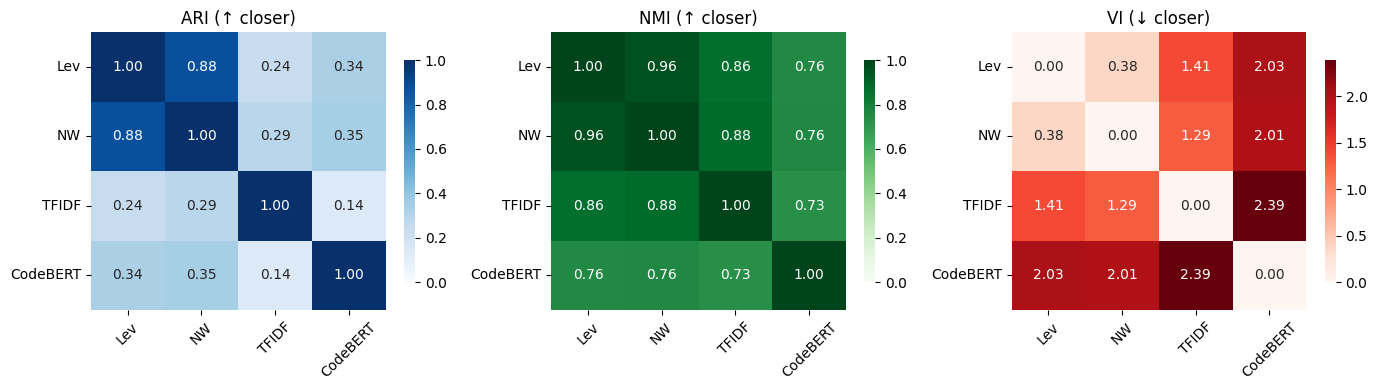

In [15]:
# === FS Eval - External agreement between best AGG configs (ARI / NMI / VI) ===

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

#---------------------------------------------------------------------
# 1) Helper: pick best AGG config for a (lane, fs_def) pair
#---------------------------------------------------------------------

def pick_best_agg_config(
    df: pd.DataFrame,
    lane: str,
    fs_def: str,
    min_clusters: int = 5,
    max_clusters: int = 250,
    max_singletons_frac: float = 0.8,
) -> pd.Series:
    """
    Pick a 'best' AGG config for a given (lane, fs_def) pair.

    Primary filters:
      - lane, fs_def, clusterer == 'AGG'
      - min_clusters <= n_clusters <= max_clusters
      - n_singletons <= max_singletons_frac * N

    If nothing survives structural filters, we relax them:
      1) keep all rows for that lane/fs_def/clusterer with non-NaN silhouette
      2) if still empty, use ALL rows for that lane/fs_def/clusterer.
    """
    # Base subset for this lane + FS definition
    base = df[
        (df["lane"] == lane)
        & (df["fs_def"] == fs_def)
        & (df["clusterer"] == "AGG")
    ].copy()

    if base.empty:
        raise ValueError(f"No AGG configs at all for lane={lane}, fs_def={fs_def}.")

    # Structural sanity filters
    sub = base[
        (base["n_clusters"] >= min_clusters)
        & (base["n_clusters"] <= max_clusters)
        & (base["n_singletons"] <= max_singletons_frac * base["N"])
    ].copy()

    if sub.empty:
        print(f"WARNING: no AGG configs for lane={lane}, fs_def={fs_def} after strict filters.")
        # Relax filters: require only a valid silhouette
        sub = base[base["silhouette"].notna()].copy()
        if sub.empty:
            print("  No configs with finite silhouette; falling back to all base configs.")
            sub = base.copy()

    # For sorting, treat missing Dunn as very bad
    sub["dunn_rank"] = sub["dunn"].fillna(-np.inf)

    # Rank: high silhouette, high Dunn, low DB, high CH
    sub = sub.sort_values(
        by=["silhouette", "dunn_rank", "davies_bouldin", "calinski_harabasz"],
        ascending=[False,   False,      True,             False],
    )

    return sub.iloc[0]



#---------------------------------------------------------------------
# 2) Select best configs for each lane / FS definition
#---------------------------------------------------------------------

targets = [
    ("Lev",      "A", "LEV"),
    ("NW",       "A", "NW"),
    ("TFIDF",    "B", "TFIDF"),
    ("CodeBERT", "C", "CODEBERT"),
]

short_labels = []
rows = []

for short, lane, fs_def in targets:
    row = pick_best_agg_config(all_results_df, lane=lane, fs_def=fs_def)
    short_labels.append(short)
    rows.append(row)

best_summary = pd.DataFrame([
    {
        "short_name": short,
        "lane": r["lane"],
        "fs_def": r["fs_def"],
        "config": r["config"],
        "tau": r.get("tau", np.nan),
        "n_clusters": r["n_clusters"],
        "n_singletons": r["n_singletons"],
        "silhouette": r["silhouette"],
        "dunn": r["dunn"],
        "davies_bouldin": r["davies_bouldin"],
    }
    for short, r in zip(short_labels, rows)
])

print("Best AGG configs used for external agreement:")
display(best_summary)

#---------------------------------------------------------------------
# 3) Build ARI / NMI / VI matrices
#---------------------------------------------------------------------

k = len(rows)
ari_mat = pd.DataFrame(np.eye(k), index=short_labels, columns=short_labels, dtype=float)
nmi_mat = pd.DataFrame(np.eye(k), index=short_labels, columns=short_labels, dtype=float)
vi_mat  = pd.DataFrame(np.zeros((k, k)), index=short_labels, columns=short_labels, dtype=float)

for i in range(k):
    for j in range(i + 1, k):
        metrics = compare_two_configs(rows[i], rows[j])
        ari = metrics["ARI"]
        nmi = metrics["NMI"]
        vi  = metrics["VI"]

        ari_mat.iloc[i, j] = ari_mat.iloc[j, i] = ari
        nmi_mat.iloc[i, j] = nmi_mat.iloc[j, i] = nmi
        vi_mat.iloc[i, j]  = vi_mat.iloc[j, i]  = vi

#---------------------------------------------------------------------
# 4) Pretty-printed tables
#---------------------------------------------------------------------

fmt3 = lambda x: f"{x:0.3f}" if pd.notna(x) else "nan"

print("\n[ARI (↑ closer)]")
print(ari_mat.to_string(float_format=fmt3))

print("\n[NMI (↑ closer)]")
print(nmi_mat.to_string(float_format=fmt3))

print("\n[VI  (↓ closer)]")
print(vi_mat.to_string(float_format=fmt3))

#---------------------------------------------------------------------
# 5) Heatmaps
#---------------------------------------------------------------------

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

sns.heatmap(
    ari_mat, ax=axes[0], vmin=0, vmax=1,
    annot=True, fmt=".2f", cmap="Blues",
    cbar_kws={"shrink": 0.8}
)
axes[0].set_title("ARI (↑ closer)")

sns.heatmap(
    nmi_mat, ax=axes[1], vmin=0, vmax=1,
    annot=True, fmt=".2f", cmap="Greens",
    cbar_kws={"shrink": 0.8}
)
axes[1].set_title("NMI (↑ closer)")

sns.heatmap(
    vi_mat, ax=axes[2],
    annot=True, fmt=".2f", cmap="Reds",
    cbar_kws={"shrink": 0.8}
)
axes[2].set_title("VI (↓ closer)")

for ax in axes:
    ax.tick_params(axis="x", rotation=45)
    ax.tick_params(axis="y", rotation=0)

plt.tight_layout()
plt.show()
